# Challenge image semantic segmentation

### Antoine Habis

### Requirements: Tensorflow==1.15.2


In [5]:
!pip install segmentation_models
import numpy as np
from scipy import ndimage
import cv2
import matplotlib.pyplot as plt
import matplotlib
import keras
import tensorflow as tf
from PIL import Image
from tqdm import tqdm_notebook
import scipy
import glob
from sklearn.model_selection import train_test_split
import time
import segmentation_models as sm
import tensorflow.compat.v1 as tf
from keras.callbacks import ModelCheckpoint
from keras import backend as K
# keras.callbacks.callbacks
from keras.optimizers import Adam

### Import images and matrices

In [6]:
K_color = np.load('DATAS/K_color_intrinsic.npy')
K_depth = np.load('DATAS/K_depth_intrinsic.npy')
K_color_depth = np.load('DATAS/T_color_to_depth_extrinsic.npy')

color_image = cv2.imread('DATAS/color_image.jpg')
depth_image_colored = cv2.imread('DATAS/depth_image_colored.jpg')
depth_image_mask = cv2.imread('DATAS/depth_image_mask.png')
bonus_image = cv2.imread('DATAS/color_image_bonus.jpg')

In [7]:
K_color_depth = K_color_depth[0:3,0:3]
nb_pixels = depth_image_colored.shape[0] * depth_image_colored.shape[1]
print(nb_pixels)

921600


In [8]:
print(depth_image_colored.shape)
print(color_image.shape)
print(depth_image_mask.shape)

(1280, 720, 3)
(1280, 720, 3)
(1280, 720, 3)


### Observation of the images

<Figure size 432x288 with 0 Axes>

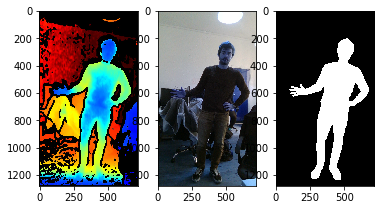

In [9]:
plt.figure()

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(1,3) 

# use the created array to output your multiple images. In this case I have stacked 4 images vertically
axarr[0].imshow(depth_image_colored)
axarr[1].imshow(color_image)
axarr[2].imshow(depth_image_mask)


#### Different type of encoding for the images


In [10]:
array_mask = depth_image_mask[:,:,0]/255
array_depth = np.float32(depth_image_colored.reshape(1280*720,3))
array_color = np.float32(color_image.reshape(1280*720,3))


### Correct the alignment of the images

In [11]:
def get_coordinate(pixel_number):
    return np.array([pixel_number % 720, pixel_number//720])


def get_number_pixel(coord):
    return coord[1]*720 + coord[0]

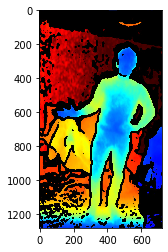

In [12]:
W = np.arange(1280*720)
P = get_coordinate(W) + 1
Q = np.vstack((P, np.ones(1280*720)))
V = np.round(np.dot(K_depth, np.dot(
    K_color_depth, np.dot(np.linalg.inv(K_color), Q)))).astype(int)
V = V[0:2]
get_number_pixel(V)
new_array = np.array([array_depth[u] for u in get_number_pixel(V)])
new_img = new_array.reshape(1280, 720, 3).astype(np.uint8)
plt.imshow((new_img))

### For the rest of the challenge we will use the new image as the depth colored image

In [13]:
depth_image_colored = new_img
array_depth = np.float32(depth_image_colored.reshape(1280*720,3))

The image of the mask can be represented as an array with size (1280, 720) (Black and White img)
However the two other images are represented by arrays with size (1280,720,3) (RGB)

### Definition of the accuracy

In [14]:
def accuracy(labels, prt=True):
    acc1 = 1 - np.sum(np.abs(labels - array_mask))/nb_pixels
    labels = 1 - labels
    acc2 = 1 - np.sum(np.abs(labels - array_mask))/nb_pixels
    if prt:
        print('the accuracy of the algorithm is {}'.format(max(acc1, acc2)))
    return max(acc1, acc2)

# Unsupervised Learning

### Observation of k-means algorithm separately on both images

#### K- means on depth image

In [15]:
compactness_d, labels_d, centers_d = cv2.kmeans(array_depth, 2, bestLabels = None,criteria = (cv2.TERM_CRITERIA_MAX_ITER, 10000, 1e-12), attempts = 5, flags = cv2.KMEANS_PP_CENTERS)

In [16]:
compactness_c, labels_c, centers_c = cv2.kmeans(array_color, 2, bestLabels = None,criteria = (cv2.TERM_CRITERIA_MAX_ITER, 10000, 1e-12), attempts = 5, flags = cv2.KMEANS_PP_CENTERS)

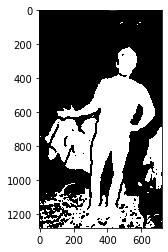

In [17]:
labels_d = labels_d.reshape(1280,720)
plt.imshow(labels_d,'gray')
plt.show() 


In [18]:
accuracy(labels_d)

the accuracy of the algorithm is 0.795419921875


0.795419921875

#### K- means on colored image

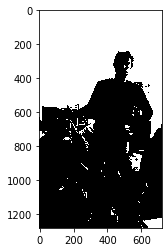

In [19]:
labels_c = labels_c.reshape(1280, 720)
plt.imshow(labels_c, 'gray')
plt.show()

In [20]:
accuracy(labels_c)

the accuracy of the algorithm is 0.5918250868055556


0.5918250868055556

### K-means with channel = 6 (the two images with 2 RGB tuples as features)

As We can see in the original images, the depth image seems to be more correlated to the target than the colored image is so let's add a compensation parameter $C = 0.5$

In [0]:
C = 0.5

In [0]:
array_concat = np.hstack((array_depth,C*array_color))

In [0]:
compactness, labels, centers = cv2.kmeans(array_concat, 2, bestLabels = None, criteria = (cv2.TERM_CRITERIA_EPS, 10, 2000), attempts = 5, flags = cv2.KMEANS_PP_CENTERS)

In [0]:
labels = labels.reshape(1280,720)
plt.imshow(labels,'gray')
plt.show() 

In [0]:
accuracy(labels)

In [0]:
acc_list = []
for u in np.linspace(10, 5000):
    v = cv2.kmeans(array_concat, 2, bestLabels=None, criteria=(
        cv2.TERM_CRITERIA_EPS, 1, u), attempts=5, flags=cv2.KMEANS_PP_CENTERS)[1]
    v = v.reshape(1280, 720)
    acc_list.append(accuracy(v, False))
plt.plot(np.linspace(10, 5000), acc_list)
plt.xlabel('epsilon')
plt.ylabel('accuracy')
plt.title('evolution of the accuracy as function of epsilon')
plt.show()

The accuracy occilates between 80% and 90% but we cannot see a pattern in the evolution of the accuracy. The optimal value of $\epsilon^*$ is too correlated with the initialization of the algorithm.

## The algorithm is not good enough, let's try to preprocess the image first:

###### Let's first try to blur the image to get rid of some misclassified isolated points

In [0]:
kernel_size = 21

### Observation of the blured images

In [0]:
# Remove noise
# Gaussian
blur_depth = cv2.GaussianBlur(
    depth_image_colored, (kernel_size, kernel_size), 0)
f, axarr = plt.subplots(1, 2)
axarr[0].imshow(depth_image_colored)
axarr[1].imshow(blur_depth)

In [0]:
blur_colored = cv2.GaussianBlur(color_image, (kernel_size, kernel_size), 0)
f, axarr = plt.subplots(1, 2)
axarr[0].imshow(color_image)
axarr[1].imshow(blur_colored)

In [0]:
blur_depth = np.float32(blur_depth.reshape(1280*720, 3))
blur_colored = np.float32(blur_colored.reshape(1280*720, 3))
array_concat_blured = np.hstack((blur_depth, C*blur_colored))
t1 = time.time()
compactness_blur, labels_blur, centers_blur = cv2.kmeans(array_concat_blured, 2, bestLabels=None, criteria=(
    cv2.TERM_CRITERIA_EPS, 500, 2000), attempts=5, flags=cv2.KMEANS_PP_CENTERS)
t2 = time.time()
print('the algorithm took {} seconds to run'.format(t2-t1))

### Accuracy with k-means with blured images

In [0]:
labels_blur = labels_blur.reshape(1280,720)
plt.imshow(labels_blur,'gray')
plt.show() 

In [0]:
accuracy(labels_blur)

We are getting closer here with an accuracy of 

$acc \approx 84\%$

In [0]:
img_blur_col = blur_colored.reshape(1280,720,3).astype('uint8')
img_blur_depth = blur_depth.reshape(1280,720,3).astype('uint8')

In [0]:
matplotlib.image.imsave('blur_color.png', img_blur_col)
matplotlib.image.imsave('blur_depth.png', img_blur_depth)

## cvtColor with adaptative threshold for binary classification

###### Let's try this  algorithm with the blured images we created previously

In [0]:
cv2.cvtColor?

In [0]:
img_d = cv2.imread('blur_depth.png')
gray_d = cv2.cvtColor(img_d,cv2.COLOR_BGR2GRAY)
ret_d, thresh_d = cv2.threshold(gray_d,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
img_output_d = np.uint8(thresh_d)/255
plt.imshow(img_output_d)

In [0]:
accuracy(img_output_d)

In [0]:
img_c = cv2.imread('blur_color.png')
gray_c = cv2.cvtColor(img_d,cv2.COLOR_BGR2GRAY)
ret_c, thresh_c = cv2.threshold(gray_c,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
img_output_c = np.uint8(thresh_c)/255
plt.imshow(img_output_c)

In [0]:
accuracy(img_output_c)

##### Now let's try with a weighted sum of the two images:

In [0]:
p = 0.2

In [0]:
mixt_img = img_blur_col*p + (1-p)*img_blur_depth
mixt_img = mixt_img.astype('uint8')
matplotlib.image.imsave('mixt.png', mixt_img)

In [0]:
img = cv2.imread('mixt.png')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
output = np.uint8(thresh)/255
plt.imshow(output)

In [0]:
accuracy(output)

The algorithm is not good enough, Kmeans is still the best option so far

# Supervised Learning

# IMPORTANT: If you don't want to load the data or train the model just execute the cell load_model



In [0]:
width = 512 #### dimension of the image to pass into the network 
height = 256
channel = 3

### Load the dataset

#### The dataset is composed of images that are divided into two parts:

- The true image on the left side
- the image with human segmentation on the right side


#### /!\   The following cell takes a lot of time to execute 




In [0]:
#### import sys
files = glob.glob("/content/drive/My Drive/DATAS/masks_human/*.png")
n = len(files)
images= []
for i, filename in enumerate(files):
  img = cv2.imread(filename)
  img = cv2.resize(img, (width,height))
  images.append(np.asarray(img))

In [0]:
images = np.asarray(images)

### observation of an image in the dataset:

In [0]:
plt.imshow(images[0])

In [0]:
# images = np.concatenate(images, axis=0)
images.shape

### First preprocessing of the data to train the model afterwards

X is the left side of the image.

To get y we need to take the left part and the right part of the images and compare them.

if any pixel value has changed then it means that this pixel belonged to the human body so we set it's value to 1. 

In [0]:
X  = images[:,:,:width//2,:]
X.shape
y  = images[:,:,width//2:,:]
y.shape

y = np.abs(y - X)
y = np.sum(y, axis = 3)
y = y>0
y = np.expand_dims(y, axis = 3)
print(y.shape)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [0]:
val1 = np.sum(y)
tot = y.shape[0]*y.shape[1]*y.shape[2]
weight = 1 -val1/tot
print('there is {}% of background in the images of the dataset'.format(round(weight*100)))

In [0]:
print(X_train.shape)
print(y_train.shape)

In [0]:
def weighted_binary_crossentropy( y_true, y_pred, weight=weight) :
    y_true = K.clip(y_true, K.epsilon(), 1-K.epsilon())
    y_pred = K.clip(y_pred, K.epsilon(), 1-K.epsilon())
    logloss = -(y_true * K.log(y_pred) * weight + (1-weight)*(1 - y_true) * K.log(1 - y_pred))
    return K.mean(logloss, axis=-1)

## Training


In [0]:
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

# preprocess input
X_train_process = preprocess_input(X_train)
X_test_process = preprocess_input(X_test)

# define model
model = sm.Unet(BACKBONE, classes=1, activation='sigmoid')
model.compile(
    optimizer=Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, amsgrad=False),
    loss=weighted_binary_crossentropy,
    metrics=[sm.metrics.iou_score],
)

# fit model
# if you use data generator use model.fit_generator(...) instead of model.fit(...)
# more about `fit_generator` here: https://keras.io/models/sequential/#fit_generator
model.fit(
    x=X_train_process,
    y=y_train,
    batch_size=32,
    epochs=40,
    callbacks=[ModelCheckpoint('/content/drive/My Drive/DATAS/unet.hdf5', monitor='val_loss',
                               verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)],
    validation_data=(X_test_process, y_test),)

In [0]:
model.load_weights('/content/drive/My Drive/DATAS/unet.hdf5')

In [0]:
img_test = cv2.resize(color_image, (width//2, height))
img_test = np.float32(img_test)
img_test.shape
test = np.expand_dims(img_test, axis=0)
test = preprocess_input(test)
test.shape

In [0]:
# img_test = cv2.resize(depth_image_colored, (width,height)).round()
# plt.imshow(img_test)
# depth_image_colored = np.float32(img_test)
# depth_image_colored.shape
# test = np.expand_dims(depth_image_colored, axis = 0)
# test = preprocess_input(test)
# test.shape

## Observation of the prediction

In [0]:
t1 = time.time()
y_predict = model.predict(test)[0][:,:,0].round()
t2 = time.time()
print('the algorithm took {} seconds to run'.format(t2-t1))
y_predict = cv2.resize(y_predict, (720,1280))
plt.imshow(y_predict)

In [0]:
accuracy(y_predict)

# Commentraries:

## For the unsupervised learning algorithm:

The algorithm has no clue what are the two classes he made with it's classification technic. We saw that the K-means worked pretty well with the depth image because the person is in the foreground so the pixels are more likely to be red and yellow. However if any object (such as the chair on the right side) are  in the foreground too, then the algorithm will classify it as belonging to the human part.


We can easily see that K-means will not work well on the color image but when we add the information of the color image to the depth image it's a bit better.

With Kmeans preprocessed (blured) using both images combined we get an accuracy of 84% which is not bad but still not incredible because the classes are unbalaced (returning a black image gives more than 70% acc). 
However, the algorithm is very fast and take 0.25 seconds to run.



The accuracy is calculated with the inverse of the MAE:
$acc = 1 - \frac{\sum_i |\hat{y_i} - y_i|}{n}$


This accuracy is the most intuitive way to evaluate the model's prediction.
We could have chosen a weighted accuracy but it's that important.


##  For supervised learning algorithm:



- The dataset on which we train is not big enough but it's an overview of what we can do with more data.


First thing to notice is that the dataset is really unbalanced. 
In the picture there are way more pixel that belong to the class background than pixels that belong to class human.

The idea is to change binary cross entropy and adjust it with weights that correspond to the proportion of the different class in the dataset.

We get a loss that is defined like this:

$loss = \frac{\sum_i -(w y_i log(\hat{y}_i) + (1-w)(1 - y_i)log(1 - \hat{y}_i))}{n}$

I chose to train with the **resnet 34** which is the best BACKBONE from all the different BACKBONE I tried (vgg6, resnet50, inceptionv3,etc,...)

The model I chose to predict the mask of the colored image is the best model according to the val_loss criteria during the backpropagation.



**To improve our segmentation:**
 As we've seen in this section, we are only using the colored image and not the depth image because we don't have a dataset with depth picture. What we could do is a probabilistic classification (for example GMM) on the depth image and combine the two predictions (with GMM with depth image and with deep learning and colored image) to get a better prediction.
 



## Going Further

- **With unsupervised learning** it is impossible to get a good segmentation of the body because of the bottom part (which is cut) in the bonus image.

- **With supervised learning** it is going to be hard because the dataset is labeled such that if there is a part of the body hidden on the picture then the hidden part will not be labeled as a part of the human body.

 1. A solution would be to train on a dataset where the segmentation is done such as if a part of the body is hidden on the picture then the  data still recognize the hidden part as belonging to the human.

 2. If we don't have such a dataset we can try something else and cut the images in the dataset ourselves. The idea would be to train a first convolutional network to reproduce the original image from the image that was cut and then apply another network for segmentation (for example the one implemented before).



## Result of supervised Learning on the bonus image

In [0]:
img_test = cv2.resize(bonus_image, (width//2,height))
img_test = np.float32(img_test)
img_test.shape
test = np.expand_dims(img_test, axis = 0)
test = preprocess_input(test)
test.shape

t1 = time.time()
y_predict = model.predict(test)[0][:,:,0].round()
t2 = time.time()
print('the algorithm took {} seconds to run'.format(t2-t1))
y_predict = cv2.resize(y_predict, (720,1280))
plt.imshow(y_predict)

In [0]:
accuracy(y_predict)

Ref I looked at:

- https://github.com/qubvel/segmentation_models
- https://www.kaggle.com/c/person-segmentation-coco
- https://github.com/matterport/Mask_RCNN
- https://www.tensorflow.org/tutorials/images/segmentation